# Group Report

## Heart Disease
    
    Nowadays, due to continuous increments of different pressure such as the ability to afford rent, comparison of salary between peers, relationships built and more, the health of our society is declining despite the development of an advanced medical system. According to the Statistic of Canada, heart disease is the second leading cause of death in Canada, with 14 deaths every hour. To add on, a study was conducted on a group of people who had experienced heart attacks, which is a symptom of heart disease. It was found that 3 out of 5 of them were undiagnosed. Preventative measures could have been taken by these people before they became patients if they were aware of the possibility of having heart disease. Therefore, we plan to create a predictive model that can determine whether someone has heart disease based on their health statistics.

    In this project, we would like to enhance the diagnosis of heart disease in both accuracy and efficiency as much as we can. Hence, our group aims to create a simple and accurate model, using K-NN classification as the main focus in this project to diagnose whether someone has heart disease. 

    In order to create our model, we will use the Heart Disease Data Set, specifically the Cleveland dataset, which was compiled by UCI. As the Cleveland dataset is the only data that has been used by researchers, we deemed that this was the most suitable dataset for our project. This is because this dataset does not have missing values. This dataset contains data from patients in 1988 and records statistics such as age, type of chest pain, and maximum heart rate. However, we will be using age, cholesterol, resting blood pressure and maximum heart rate as our predictor variables. We chose these variables because they are essential risk factors according to a research article (Wilson, 1998) and (Hajar, 2017). To improve the accuracy of our model, we will implement forward selection to explore which of these variables would be optimal to predict our model.

In [25]:
# The different libraries required
library(tidyverse)
library(repr)
library(tidymodels)
library(digest)
library(cowplot)
library(infer)
library(gridExtra)
options(repr.matrix.max.rows = 6)

The columns in this dataset are:
1. Age - (years)
2. Sex - (1 = male, 0 = female)
3. Chest Pain Type - (1 = typical angina)
                     (2 = atypical angina)
                     (3 = non-anginal pain)
                     (4 = asymptomatic)
4. Resting Blood Pressure - (mm Hg)
5. Cholesterol -(mg/dl)
6. Fasting Blood Sugar - (> 120 mg/dl)
                       - (1 = true; 0 = false)
7. Resting Electrocardiogram
8. Maximum heart rate
9. Exercised induced angina - (1 = yes; 0 = no)
10. ST depression induced by exercise relative to rest
11. Slope of peak exercise ST segment
12. Number of major vessels 
13. Blood disorder - 3 = normal
                     6 = fixed defect
                     7 = reversible defect
14. Heart disease status - (1 = yes, 0 = no)

In [26]:
set.seed(20)

heart_data_1 <- read_csv("data/processed.cleveland (1).data", col_names = FALSE) |>
                mutate(X14 = as_factor(X14)) 
                
colnames(heart_data_1) <- c("age","sex","cp","trestbps","chol","fbs","restecg","thalach",
                                    "exang","oldpeak","slope","ca","thal","num") 

heart_data <- heart_data_1 |>
                mutate(num=recode(num, "0" = "0",
                                       "1" = "1",
                                       "2" = "1",
                                       "3" = "1",
                                       "4" = "1"))
heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,1
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


                                                Fig1.0

First, we set the seed as 20 to ensure that our results are reproducible. Next, we downloaded the Heart Disease Data Set at Cleveland, from GitHub to observe the heart statistics. Following on, we read the .csv file into R using read_csv. We didn't clean the data into tidy data, as the data is already tidy.

In [27]:
nrow(heart_data) 
heart_proportion <- heart_data |>
                    group_by(num) |>
                    summarise(n=n()) |>
                    mutate(proportion= n/303)
                    
heart_proportion

[1] 303

num,n,proportion
<fct>,<int>,<dbl>
0,164,0.5412541
1,139,0.4587459


        Fig1.1

This summary represents the proportion of patients having heart disease, and it shows that our data is not biased as there is a good amount of both data. 

In [28]:
set.seed(20)
heart_split <- initial_split(heart_data, prop = 0.75, strata = num) 
heart_train <- training(heart_split)
heart_test <- testing(heart_split) 

We split our data into 75% of training data and 25% of testing data. This ensures that we have a large enough dataset for both the training and testing data.

In [30]:
nrow(heart_train)
heart_proportion <- heart_train |>
                    group_by(num) |>
                    summarise(n=n()) |>
                    mutate(proportion= n/227)
                    
heart_proportion

[1] 227

num,n,proportion
<fct>,<int>,<dbl>
0,123,0.5418502
1,104,0.4581498


        Fig1.2

This summary table shows the proportion of patients having heart disease in the training dataset.

# Method
First, we want to implement the forward selection to figure out which predictors out of age, cholesterol, maximum heart rate and resting blood pressure is the best for predicting our model. 

In [14]:
# forward selection
heart_subset <- heart_data |>
    select(num, age, chol, thalach, trestbps)

names <- colnames(heart_subset |> 
                  select(age, chol, thalach, trestbps))

example_formula <- paste("num", "~", paste(names, collapse="+"))

# create a tibble to store results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
heart_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# create 10 fold cross validation object
heart_vfold <- vfold_cv(heart_subset, v = 10, strata = num)

# store the number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        preds_new <- c(selected, names [[j]])
        model_string <- paste("num", "~", paste(preds_new, collapse="+"))
        
        #create a recipe from the model string
        heart_recipe <- recipe(as.formula(model_string),
                               data = heart_subset) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors())
        
        # tune the KNN classifier with these predictors,
        # collect accuracy for the best K
        
        acc <- workflow() |>
        add_recipe(heart_recipe) |>
        add_model(heart_model) |>
        tune_grid(resamples = heart_vfold, grid = 10) |>
        collect_metrics() |>
        filter(.metric == "accuracy") |>
        summarize(mx = max(mean))
        acc <- acc$mx |> unlist()
        
        # add this result to the dataframe
        
        accs[[j]] <- acc
        models[[j]] <- model_string
        
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |>
        add_row(size = i,
               model_string = models[[jstar]],
               accuracy = accs[[jstar]])
    selected <- c(selected, names [[jstar]])
    names <- names[-jstar]
}
accuracies              

size,model_string,accuracy
<int>,<chr>,<dbl>
1,num ~ thalach,0.6665146
2,num ~ thalach+age,0.7157694
3,num ~ thalach+age+trestbps,0.6830664
4,num ~ thalach+age+trestbps+chol,0.6770671


                       Fig1.3

We found from the forward selection that the best predictors we should use are age and maximum heart rate as the accuracy for those predictors is the highest at 71.6%.

Next, we want to plot a graph of maximum heart rate against age to visualize their relationship.

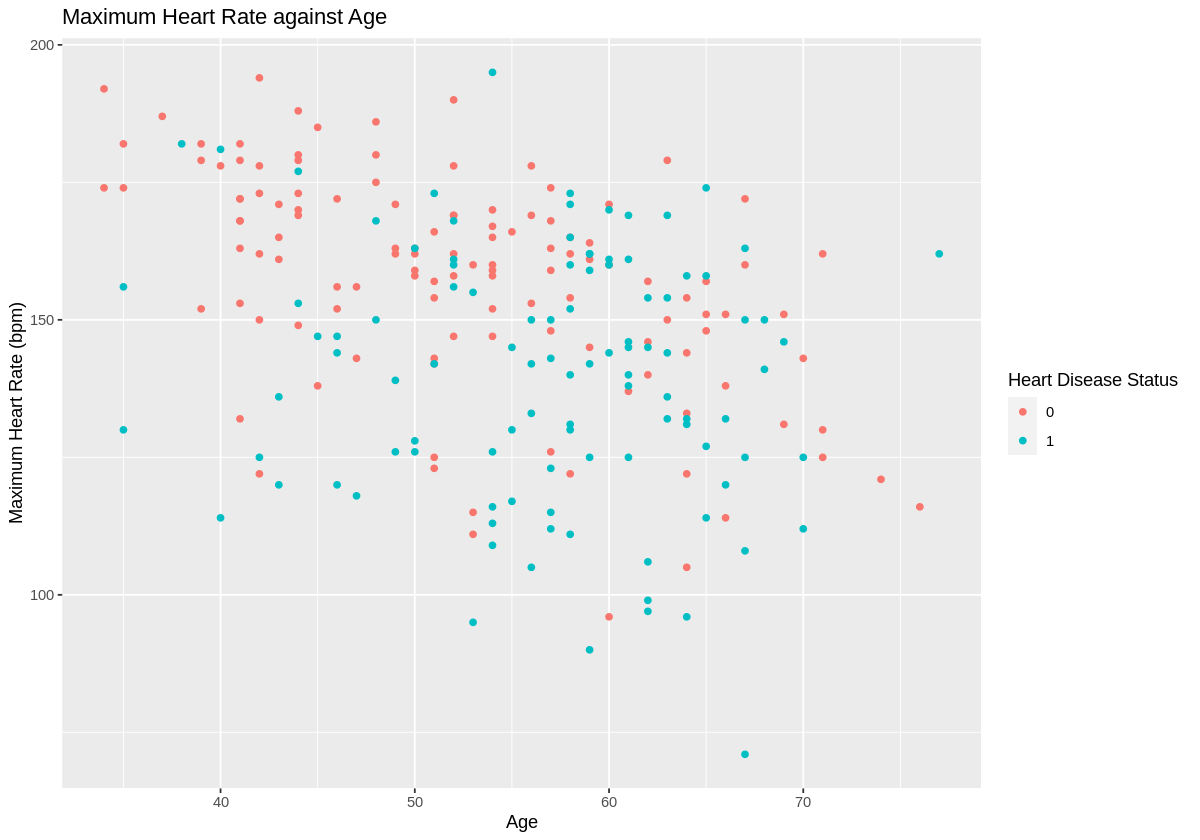

In [23]:
options(repr.plot.width = 10, repr.plot.height = 7)
heart_plot<- heart_train |>
            ggplot(aes (x = age, y = thalach, color = num)) +
            geom_point() +
            labs(x = "Age", y = "Maximum Heart Rate (bpm)", color = "Heart Disease Status") +
            ggtitle("Maximum Heart Rate against Age")
heart_plot

                                Fig1.4

Fig1.3 shows that with increasing age, there is a higher chance of having heart disease. This is shown as more blue data points with increasing age. However, for maximum heart rate, the plot is scattered, hence we are unable to say much. However, because the forward selection informed us that these two variables would best predict our model, we would still use these two variables.

Next, we created a recipe for our model to include age, and maximum heart rate as the variables we want to use to predict whether our patient has heart disease. We assigned this object 'heart_recipe'. Next, we want to perform cross-validation to decide the most accurate K value we should use, hence we created a model with the tune as neighbours. This model is assigned 'heart_model'.

In [24]:
set.seed(20)

heart_recipe <- recipe(num ~ age + thalach, data = heart_train) |>
                step_center(all_predictors()) |>
                step_scale(all_predictors())

heart_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

We separated the data into 10 subsets of data to run the cross-validation and assigned it 'heart_vfold'. We chose 10-fold cross-validation because 10 is sufficient enough for a low standard error, hence improving the accuracy of our predicting model. Next, we want to run the cross-validation with different values of K-nearest neighbours, hence we assigned that object 'gridvals'. After that, we added the recipe and model into a workflow and assigned it 'heart_results' to assess the accuracy of our predicting model with 1-30 values of K. 

In [27]:
set.seed(20)

heart_vfold <- vfold_cv(heart_train, v = 10, strata = num)

gridvals <- tibble(neighbors = seq(from = 1, to = 30))

heart_results <- workflow() |>
              add_recipe(heart_recipe) |>
              add_model(heart_model) |>
              tune_grid(resamples = heart_vfold, grid = gridvals) |>
              collect_metrics() |>
              filter(.metric == "accuracy")
heart_results


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5607049,10,0.03906514,Preprocessor1_Model01
2,accuracy,binary,0.5607049,10,0.03906514,Preprocessor1_Model02
3,accuracy,binary,0.5900198,10,0.03290127,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,accuracy,binary,0.6824769,10,0.03178630,Preprocessor1_Model28
29,accuracy,binary,0.6695982,10,0.03382308,Preprocessor1_Model29
30,accuracy,binary,0.6741436,10,0.03223762,Preprocessor1_Model30


                                Fig1.5

The Fig1.4 shows the accuracy of using 1 to 30 K-nearest neighbours. However, to visualize the optimal K-nearest neighbour, we want to plot a graph of the K-nearest neighbour against accuracy.

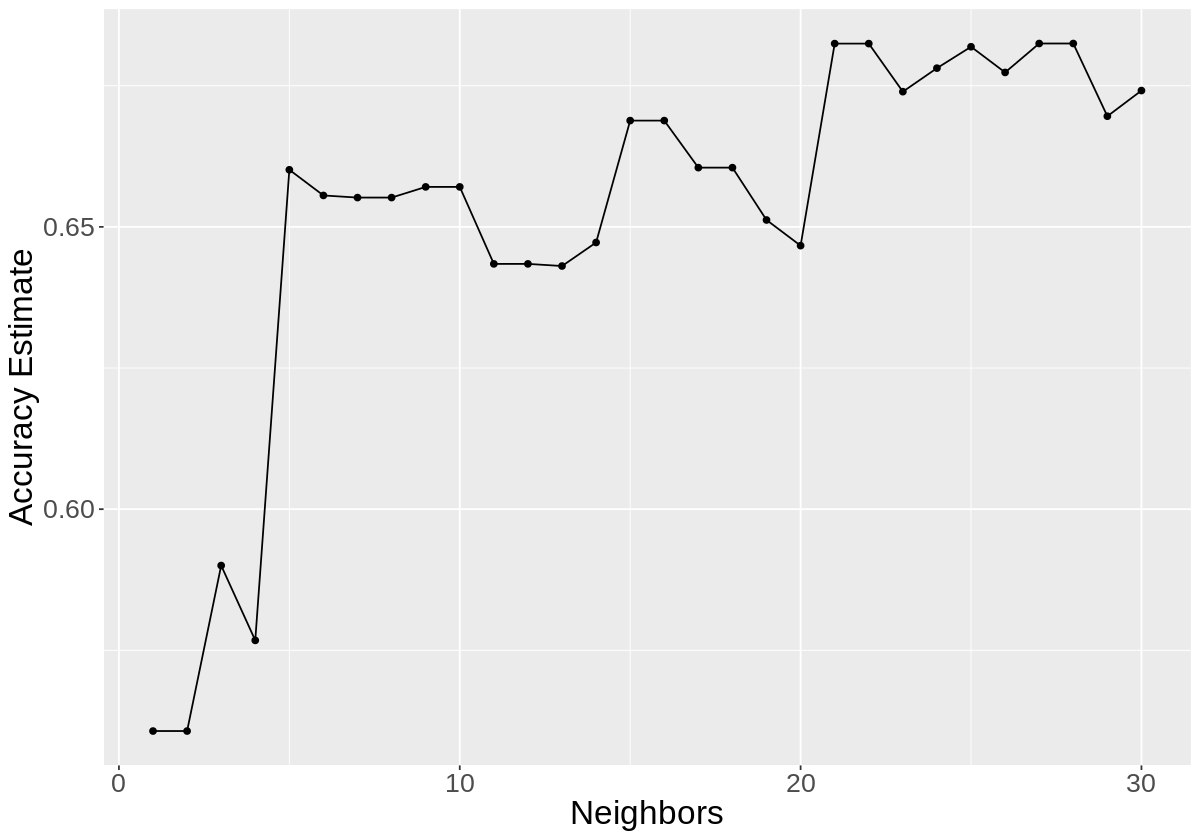

In [28]:
heart_k_plot <- heart_results |> 
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "Neighbors", y = "Accuracy Estimate") +
                theme(text = element_text(size = 20))
heart_k_plot

                                     Fig1.6

Our graph shows that using either K= 21 or 22 would provide us with the optimal accuracy, hence we will build a model using K=22.

In [29]:
set.seed(20)

best_heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 22) |>
                set_engine("kknn") |>
                set_mode("classification")

best_heart_fit <- workflow() |>
                add_recipe(heart_recipe) |>
                add_model(best_heart_spec) |>
                fit(data = heart_train)

best_heart_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(22,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3348018
Best kernel: rectangular
Best k: 22

Finally, we want to use our model to predict on the test dataset to figure out whether a patient has heart disease, which we assigned our object 'heart_predictions'. Next, we find the accuracy our model has in predicting and assigned our object 'heart_metrics'.

In [33]:
set.seed(20)

heart_predictions <- predict(best_heart_fit, heart_test) |>
                    bind_cols(heart_test)

heart_metrics <- heart_predictions |>
                metrics(truth = num, estimate = .pred_class)
heart_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7894737
kap,binary,0.5763066


                Fig1.7

Fig1.7 shows that the accuracy of our model is 78.9%. 

In [34]:
heart_conf_mat <- heart_predictions |>
                conf_mat(truth = num, estimate = .pred_class)
heart_conf_mat

          Truth
Prediction  0  1
         0 33  8
         1  8 27

        Fig1.8

Fig1.8 is the confusion matrix, which shows how many numbers of predictions were right and wrong in predicting heart disease.

Next, we want to visualize the proportions of right and wrong predictions, hence we plotted a pie chart.

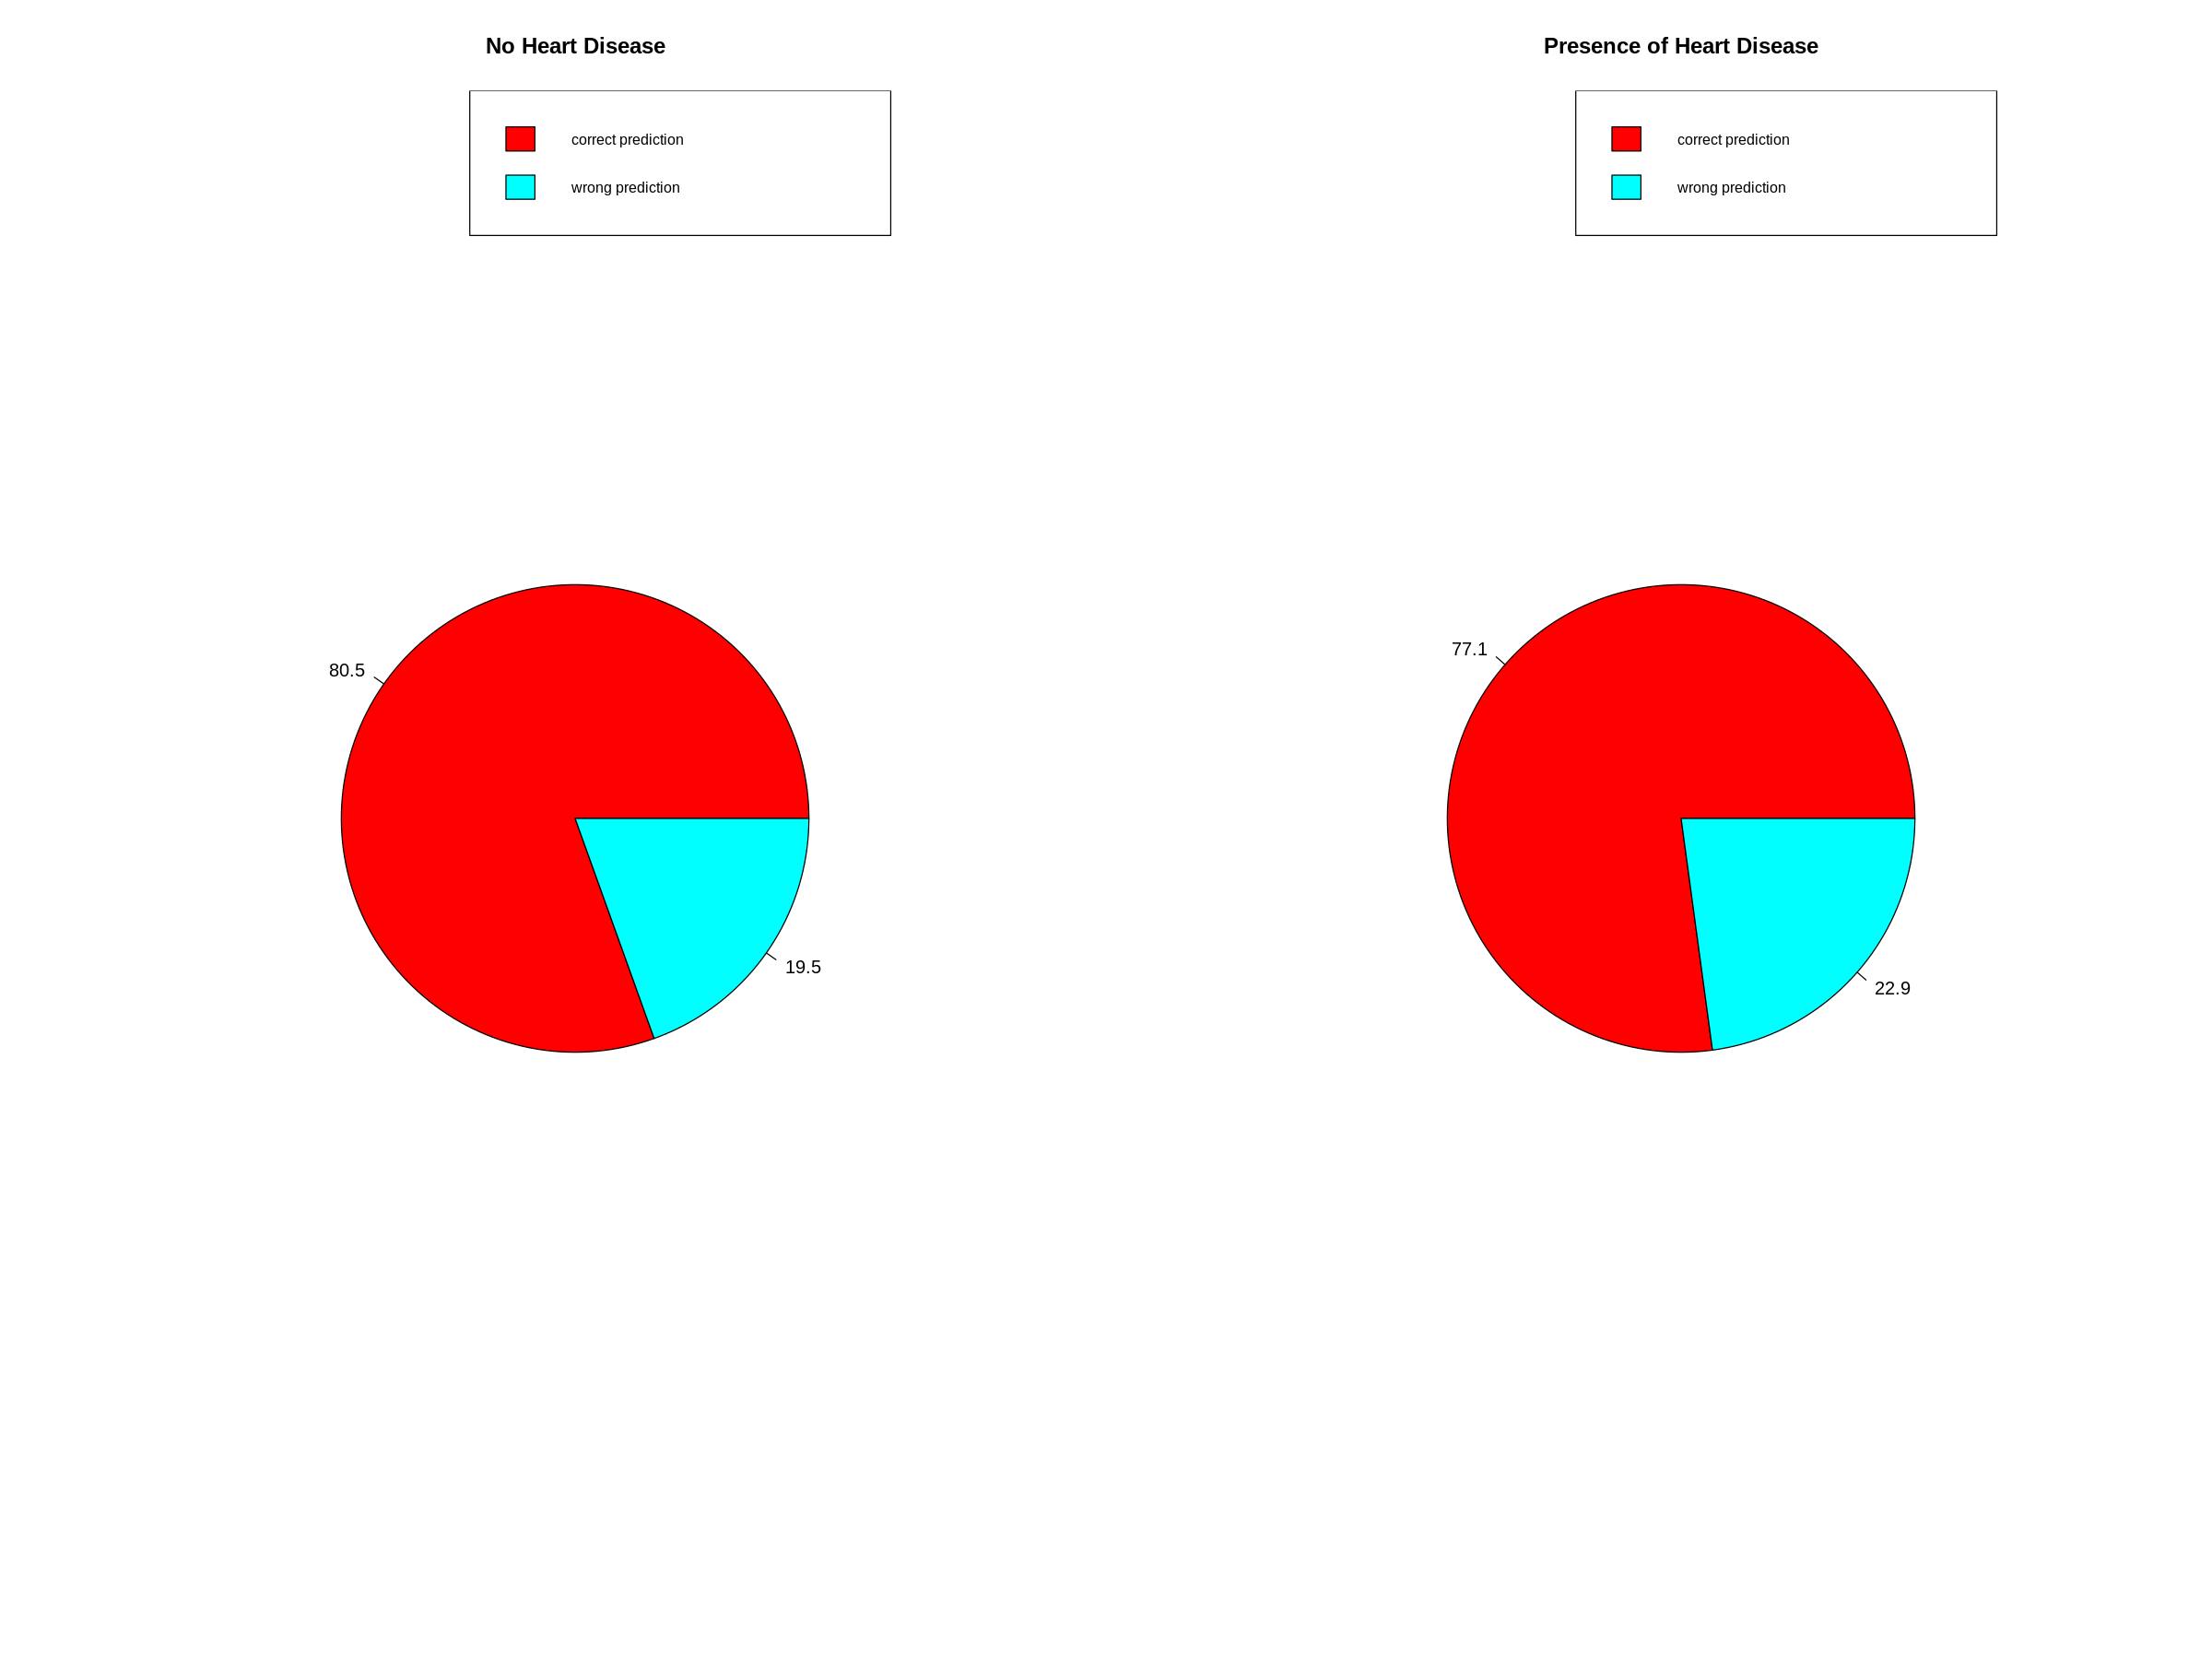

In [21]:
options(repr.plot.width = 20, repr.plot.height = 15)
par(mfrow=c(1,2))
slices <- c(33, 8)
labels <- c("correct prediction", "wrong prediction")
pct <- round(100*slices/sum(slices), 1)
pie(slices,labels = pct, main = "No Heart Disease" ,col=rainbow(length(labels))) 
    legend("topright", c("correct prediction", "wrong prediction"),
    cex = 0.8, fill = rainbow(length(slices)))

slices_1 <- c(27, 8)
labels_1 <- c("correct prediction", "wrong prediction")
pct_1 <- round(100*slices_1/sum(slices_1), 1)
pie(slices_1,labels = pct_1, main = "Presence of Heart Disease" ,col=rainbow(length(labels_1)))
           legend("topright", c("correct prediction", "wrong prediction"),
                  cex = 0.8, fill = rainbow(length(slices_1)))


                                                        Fig1.9

These pie charts show how well our model does in predicting heart disease. We can see that when predicting no heart disease, our model correctly predicts 80.5% of our testing data. However, when predicting presence of heart disease, our model correctly predicts 77.1% of our testing data.

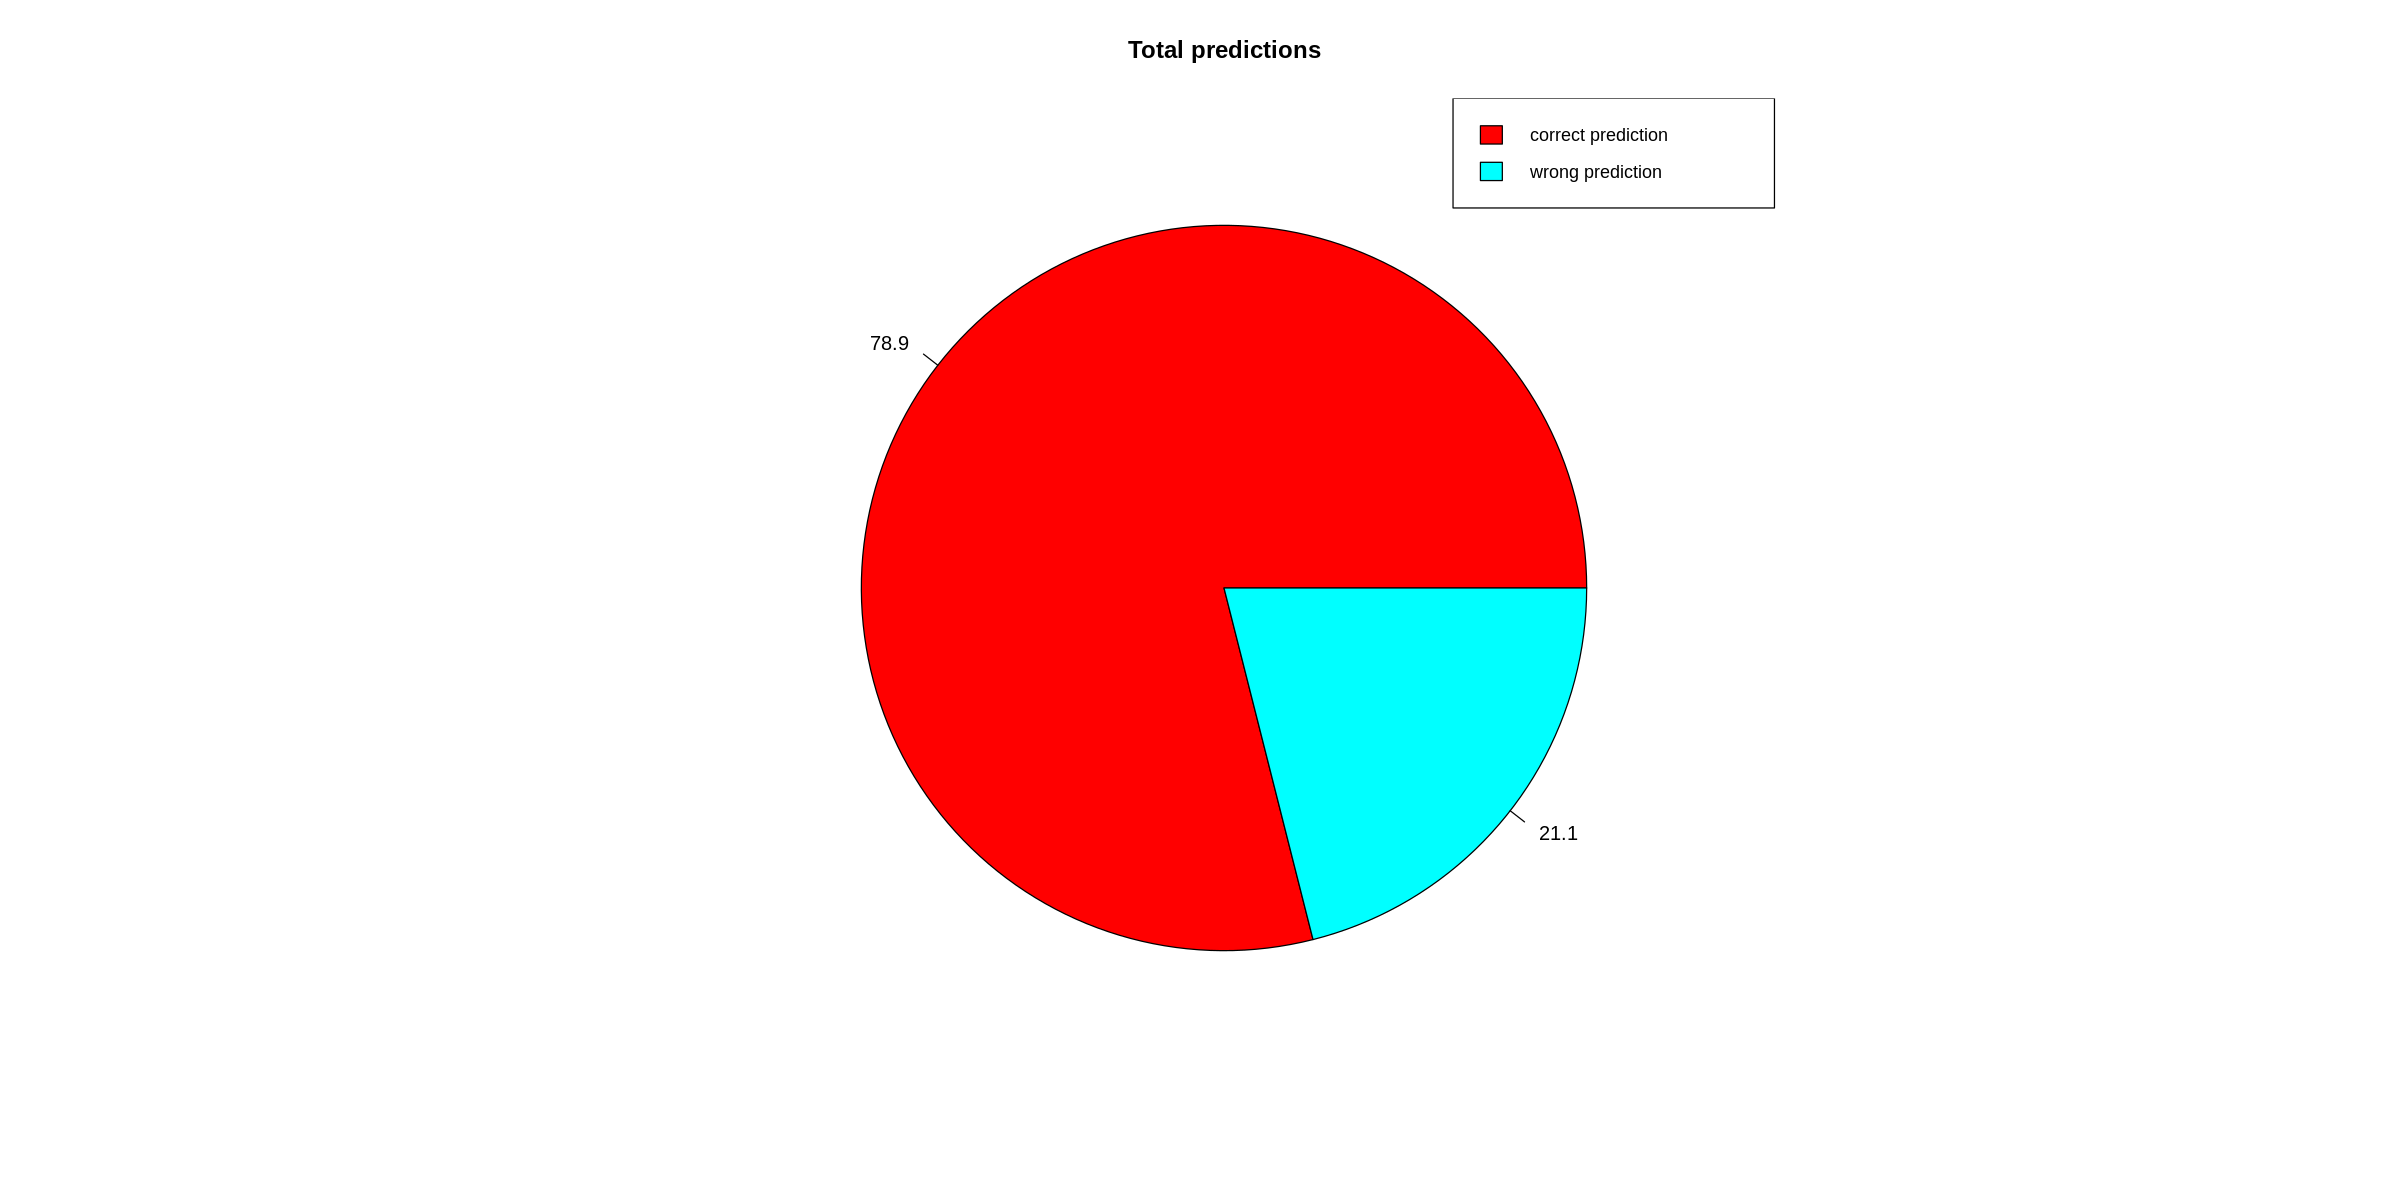

In [24]:
options(repr.plot.width = 20, repr.plot.height = 10)
slices <- c(60, 16)
labels <- c("correct prediction", "wrong prediction")
pct <- round(100*slices/sum(slices), 1)
pie(slices,labels = pct, main = "Total predictions" ,col=rainbow(length(labels))) 
    legend("topright", c("correct prediction", "wrong prediction"),
    cex = 0.9, fill = rainbow(length(slices)))

                                                            Fig2.0

This pie chart shows that our model is accurate in predicting the presence and absence of heart disease by 78.9% of our testing data.  

# Summary

Our project was based on the Cleveland dataset, compiled by UCI. From this, we created a prediction model for classifying whether a patient has heart disease based on the age and maximum heart rate of the patient. The heart disease status given by the dataset ranged from 0 to 4, where 0 means there is no heart disease and 1 to 4 represents an increasing severity of heart disease. However, we modified the severity of heart disease into the presence of heart disease. Then, we implemented forward selection to select the most important classifiers and performed K-NN classification on the training dataset. After this, we created a recipe based on the training dataset and found the optimal number of K-nearest neighbours to be 22. Finally, we used our model to test the accuracy of predicting our testing dataset. Our model achieved an accuracy of 78.9%.

# Discussion
## Expectations of our results
From Fig1.6, we found that the accuracy of our model is 78.9%, and a visualization of this is shown in Fig1.9. However, in Fig1.2, patients without heart disease represent the majority of the training data, comprising of 54.2%. Hence the majority classifier has an accuracy of 54.2%. The K-nearest neighbours classifier that we built shows a more accurate prediction of 78.9%. This means that from the perspective of accuracy, the K-nearest neighbours classifier that we built improves quite significantly on the basic majority classifier.

However, we need to be cautious when using this model as the accuracy is fairly low. It is important to not misdiagnose any patients to avoid missing patients who require preventative medical care. Fig1.9 shows that a significant proportion of 22.9% of patients is misdiagnosed. Therefore, even though the accuracy of our model improved upon the majority classifier, we analyzed that this classifier does not have appropriate performance for predicting whether a patient has heart disease. We believe that the cause of this is due to the external factors that would affect whether a patient has heart disease. For example, if someone had another disease such as diabetes or obesity, it would increase their chances of having heart disease, and this presence of another disease is not included in our model. Moreover, whether a patient smokes or not would also affect the presence of heart disease and this factor is not included in our model. Hence, the accuracy of our model was what we predicted as using age and maximum heart rate as our only predictor variables are insufficient enough to predict whether someone has heart disease. 

## Impact of findings
Through these findings, our classifier can help doctors, researchers and patients in predicting whether a patient has heart disease based on their health statistics. This can lead to an earlier diagnosis of heart disease which will allow patients and doctors to take preventative measures to prevent the deterioration of heart disease. This will avoid preventable deaths caused by symptoms of heart disease such as heart attacks and strokes if the symptoms are treated earlier on. 

## Future questions
As our model’s accuracy is fairly low, it leads us to the question of what other variables could also be used to improve our model in accurately predicting the presence of heart disease. In our model, we only focused on the most important predictors, provided by forward selection. However, from the expectations of our results, we know other external factors such as diabetes, obesity and the presence of smoking can affect the presence of heart disease. Hence, we can include data relevant to those factors and use those variables in the forward selection to reselect which combination of variables will result in the optimal accuracy of our model.


                                            References
                                            
Detrano, R., Janosi, A., Steinbrunn, W., & Pfisterer, M. (1988). Heart Disease Data Set.     https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Government of Canada. (2017). Heart disease in Canada: Highlights from the Canadian Chronic Disease Surveillance System. Retrieved from:
https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada-fact-sheet.html
   
Hajar, R. (2017). Risk factors of Coronary Heart Disease: historical perspectives. Heart Views, 18(3), 109-114. https://doi.org/10.4103/HEARTVIEWS.HEARTVIEWS_106_17 

Williamson, L. (2022). Undiagnosed heart disease may be common in people with heart attacks not caused by clots. American Heart Association. Retreived from:
https://www.heart.org/en/news/2022/03/28/undiagnosed-heart-disease-may-be-common-in-people-with-heart-attacks-not-caused-by-clots#:~:text=Advanced%20heart%20imaging%20tests%20showed,heart%20failure%20or%20sudden%20death.

Wilson, P. W. F., D'Agostino, R. B., Levy, D., Belanjer, A. M., Silbershatz, H., & Kannel, W.B. (1998). Prediction of Coronary Heart Disease Using Risk Categories. Circulation, 97(18), 1837-1847. https://doi.org/10.1161/01.CIR.97.18.1837